In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mldata/corpus.txt
/kaggle/input/mldata/test.txt


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Extracting aroumd 60 features per work 

In [3]:
def create_word_features(word):
    word = word.lower().strip()
    if not word or not word.isalpha():
        return None

    features = {
        'word': word,
        'length': len(word)
    }

    features['first_letter'] = word[0]
    features['last_letter'] = word[-1]

    vowels = set('aeiou')
    vowel_count = sum(1 for c in word if c in vowels)
    consonant_count = sum(1 for c in word if c.isalpha() and c not in vowels)
    features['has_vowel'] = 1 if vowel_count > 0 else 0
    features['vowel_count'] = vowel_count
    features['consonant_count'] = consonant_count

    # Letter Diversity 
    unique_letters = len(set(word))
    features['unique_letters'] = unique_letters
    features['letter_diversity'] = unique_letters / len(word) if len(word) > 0 else 0

    # Positional features
    max_positions = 25
    for pos in range(max_positions):
        if pos < len(word):
            features[f'pos_{pos}'] = word[pos]
        else:
            features[f'pos_{pos}'] = None

    # Letter Frequency Features - CORRECTED!
    # Initialize all to 0 first
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features[f'freq_{letter}'] = 0
    
    # Then count frequencies
    for char in word:
        if char.isalpha():
            features[f'freq_{char}'] += 1

    return features
    

    
    
    
    

# Dataframe creators

In [4]:
def create_dataframe_from_file(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        words = [line.strip() for line in f if line.strip()]

    print(len(words))

    features_list = [] 
    skipped = 0 

    for word in words:
        word_features = create_word_features(word)
        if word_features:
            features_list.append(word_features)
        else:
            skipped += 1

    df = pd.DataFrame(features_list)

    print(f"length of the dataframe:{len(df)}")
    print(f"Dataframe_shape: {df.shape}")

    return df 

    

# Create Dataloaders

In [5]:
class HangmanDataLoader:
    def __init__(self, dataframe, batch_size=32, shuffle=True):  # Fixed: shuffle not shiffle
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.shuffle = shuffle  # Fixed typo
        self.n_samples = len(self.df)
        self.n_batches = int(np.ceil(self.n_samples / batch_size))
        
        print(f"  - Total samples: {self.n_samples}")
        print(f"  - Batch size: {self.batch_size}")
        print(f"  - Number of batches: {self.n_batches}")
        print(f"  - Shuffle: {self.shuffle}")

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        if self.shuffle:
            indices = np.random.permutation(self.n_samples)
        else:
            indices = np.arange(self.n_samples)
        
        for i in range(0, self.n_samples, self.batch_size):
            batch_indices = indices[i:i + self.batch_size]
            batch = self.df.iloc[batch_indices]
            yield batch

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min(start + self.batch_size, self.n_samples)
        return self.df.iloc[start:end]

    def get_batch(self, batch_idx):
        return self.__getitem__(batch_idx)

    def get_all_data(self):
        return self.df
    
        
        

        

# VIZULATION


In [6]:
def analyze_dataframe(df, dataset_name="Dataset"):
    """Analyze and visualize DataFrame statistics"""
    print(f"\n{'='*60}")
    print(f"ANALYZING: {dataset_name}")
    print(f"{'='*60}")
    
    # Basic stats
    print(f"\n📊 Dataset Statistics:")
    print(f"  Total words: {len(df)}")
    print(f"  Unique words: {df['word'].nunique()}")
    print(f"  Average length: {df['length'].mean():.2f}")
    print(f"  Min length: {df['length'].min()}")
    print(f"  Max length: {df['length'].max()}")
    print(f"  Average vowel count: {df['vowel_count'].mean():.2f}")
    print(f"  Average unique letters: {df['unique_letters'].mean():.2f}")
    print(f"  Average letter diversity: {df['letter_diversity'].mean():.3f}")
    
    # Top features
    print(f"\n🔤 Most common first letters:")
    print(df['first_letter'].value_counts().head(5))
    
    print(f"\n🔤 Most common last letters:")
    print(df['last_letter'].value_counts().head(5))
    
    print(f"\n📏 Length distribution:")
    print(df['length'].value_counts().sort_index().head(10))
    
    return {
        'total_words': len(df),
        'unique_words': df['word'].nunique(),
        'avg_length': df['length'].mean(),
        'min_length': df['length'].min(),
        'max_length': df['length'].max()
    }


def plot_feature_distributions(corpus_df, test_df):
    """Plot comparison of features between corpus and test"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Plot 1: Length distribution
    axes[0, 0].hist(corpus_df['length'], bins=20, alpha=0.6, label='Corpus', color='blue')
    axes[0, 0].hist(test_df['length'], bins=20, alpha=0.6, label='Test', color='red')
    axes[0, 0].set_xlabel('Word Length')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Word Length Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Vowel count
    axes[0, 1].hist(corpus_df['vowel_count'], bins=10, alpha=0.6, label='Corpus', color='blue')
    axes[0, 1].hist(test_df['vowel_count'], bins=10, alpha=0.6, label='Test', color='red')
    axes[0, 1].set_xlabel('Vowel Count')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Vowel Count Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Letter diversity
    axes[0, 2].hist(corpus_df['letter_diversity'], bins=20, alpha=0.6, label='Corpus', color='blue')
    axes[0, 2].hist(test_df['letter_diversity'], bins=20, alpha=0.6, label='Test', color='red')
    axes[0, 2].set_xlabel('Letter Diversity')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Letter Diversity Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: First letter frequency (top 15)
    first_corpus = corpus_df['first_letter'].value_counts().head(15)
    first_test = test_df['first_letter'].value_counts().head(15)
    x = np.arange(len(first_corpus))
    width = 0.35
    axes[1, 0].bar(x - width/2, first_corpus.values, width, label='Corpus', alpha=0.8, color='blue')
    axes[1, 0].bar(x + width/2, first_test.values, width, label='Test', alpha=0.8, color='red')
    axes[1, 0].set_xlabel('First Letter')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Top 15 First Letters')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(first_corpus.index)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 5: Last letter frequency (top 15)
    last_corpus = corpus_df['last_letter'].value_counts().head(15)
    last_test = test_df['last_letter'].value_counts().head(15)
    x = np.arange(len(last_corpus))
    axes[1, 1].bar(x - width/2, last_corpus.values, width, label='Corpus', alpha=0.8, color='blue')
    axes[1, 1].bar(x + width/2, last_test.values, width, label='Test', alpha=0.8, color='red')
    axes[1, 1].set_xlabel('Last Letter')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Top 15 Last Letters')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(last_corpus.index)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Unique letters
    axes[1, 2].hist(corpus_df['unique_letters'], bins=15, alpha=0.6, label='Corpus', color='blue')
    axes[1, 2].hist(test_df['unique_letters'], bins=15, alpha=0.6, label='Test', color='red')
    axes[1, 2].set_xlabel('Unique Letters')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Unique Letters Distribution')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dataloader_feature_analysis.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved: dataloader_feature_analysis.png")
    plt.show()


# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":
    print("\n" + "="*60)
    print("HANGMAN DATALOADER - 60 FEATURE EXTRACTION")
    print("="*60)
    
    # ========================================
    # STEP 1: Create DataFrames
    # ========================================
    print("\n[STEP 1] Creating DataFrames from text files...")
    
    corpus_df = create_dataframe_from_file('/kaggle/input/mldata/corpus.txt')
    test_df = create_dataframe_from_file('/kaggle/input/mldata/test.txt')
    
    # ========================================
    # STEP 2: Display Sample Data
    # ========================================
    print("\n[STEP 2] Sample data from corpus...")
    print("\n📋 First 5 rows (selected columns):")
    sample_cols = ['word', 'length', 'first_letter', 'last_letter', 
                   'vowel_count', 'unique_letters', 'letter_diversity']
    print(corpus_df[sample_cols].head())
    
    print("\n📋 Positional features sample (first 3 words):")
    pos_cols = ['word'] + [f'pos_{i}' for i in range(10)]
    print(corpus_df[pos_cols].head(3))
    
    print("\n📋 Letter frequency features sample (first 3 words):")
    freq_cols = ['word'] + [f'freq_{l}' for l in 'aeiou']
    print(corpus_df[freq_cols].head(3))
    
    # ========================================
    # STEP 3: Verify Feature Count
    # ========================================
    print("\n[STEP 3] Verifying feature count...")
    print(f"\n✓ Corpus DataFrame columns: {len(corpus_df.columns)}")
    print(f"✓ Test DataFrame columns: {len(test_df.columns)}")
    
    print("\n📊 Feature breakdown:")
    print(f"  - Basic metadata: 2 (word, length)")
    print(f"  - Boundary features: 2 (first_letter, last_letter)")
    print(f"  - Vowel/consonant: 3 (has_vowel, vowel_count, consonant_count)")
    print(f"  - Diversity: 2 (unique_letters, letter_diversity)")
    print(f"  - Positional: 25 (pos_0 to pos_24)")
    print(f"  - Letter frequency: 26 (freq_a to freq_z)")
    print(f"  - TOTAL: 60 features")


HANGMAN DATALOADER - 60 FEATURE EXTRACTION

[STEP 1] Creating DataFrames from text files...
50000
length of the dataframe:49979
Dataframe_shape: (49979, 60)
2000
length of the dataframe:2000
Dataframe_shape: (2000, 60)

[STEP 2] Sample data from corpus...

📋 First 5 rows (selected columns):
               word  length first_letter last_letter  vowel_count  \
0       suburbanize      11            s           e            5   
1            asmack       6            a           k            2   
2         hypotypic       9            h           c            2   
3  promoderationist      16            p           t            7   
4       consonantly      11            c           y            3   

   unique_letters  letter_diversity  
0               9          0.818182  
1               5          0.833333  
2               7          0.777778  
3              11          0.687500  
4               8          0.727273  

📋 Positional features sample (first 3 words):
          word po


[STEP 4] Saving DataFrames to CSV...
✓ Saved: corpus_features.csv
✓ Saved: test_features.csv

[STEP 5] Creating DataLoaders...
  - Total samples: 49979
  - Batch size: 64
  - Number of batches: 781
  - Shuffle: True
  - Total samples: 2000
  - Batch size: 32
  - Number of batches: 63
  - Shuffle: False

[STEP 6] Testing DataLoader iteration...

🔄 Getting first batch from corpus loader:
Batch shape: (64, 60)

First 3 words in batch:
               word  length  vowel_count
4198   spaciousness      12            5
49626         sitch       5            1
29891       skimmed       7            2

🔄 Iterating through first 3 batches:
  Batch 1: 64 samples, avg length: 10.05
  Batch 2: 64 samples, avg length: 10.05
  Batch 3: 64 samples, avg length: 9.41

[STEP 7] Analyzing DataFrames...

ANALYZING: CORPUS

📊 Dataset Statistics:
  Total words: 49979
  Unique words: 49397
  Average length: 9.50
  Min length: 1
  Max length: 24
  Average vowel count: 3.75
  Average unique letters: 7.51
  Ave

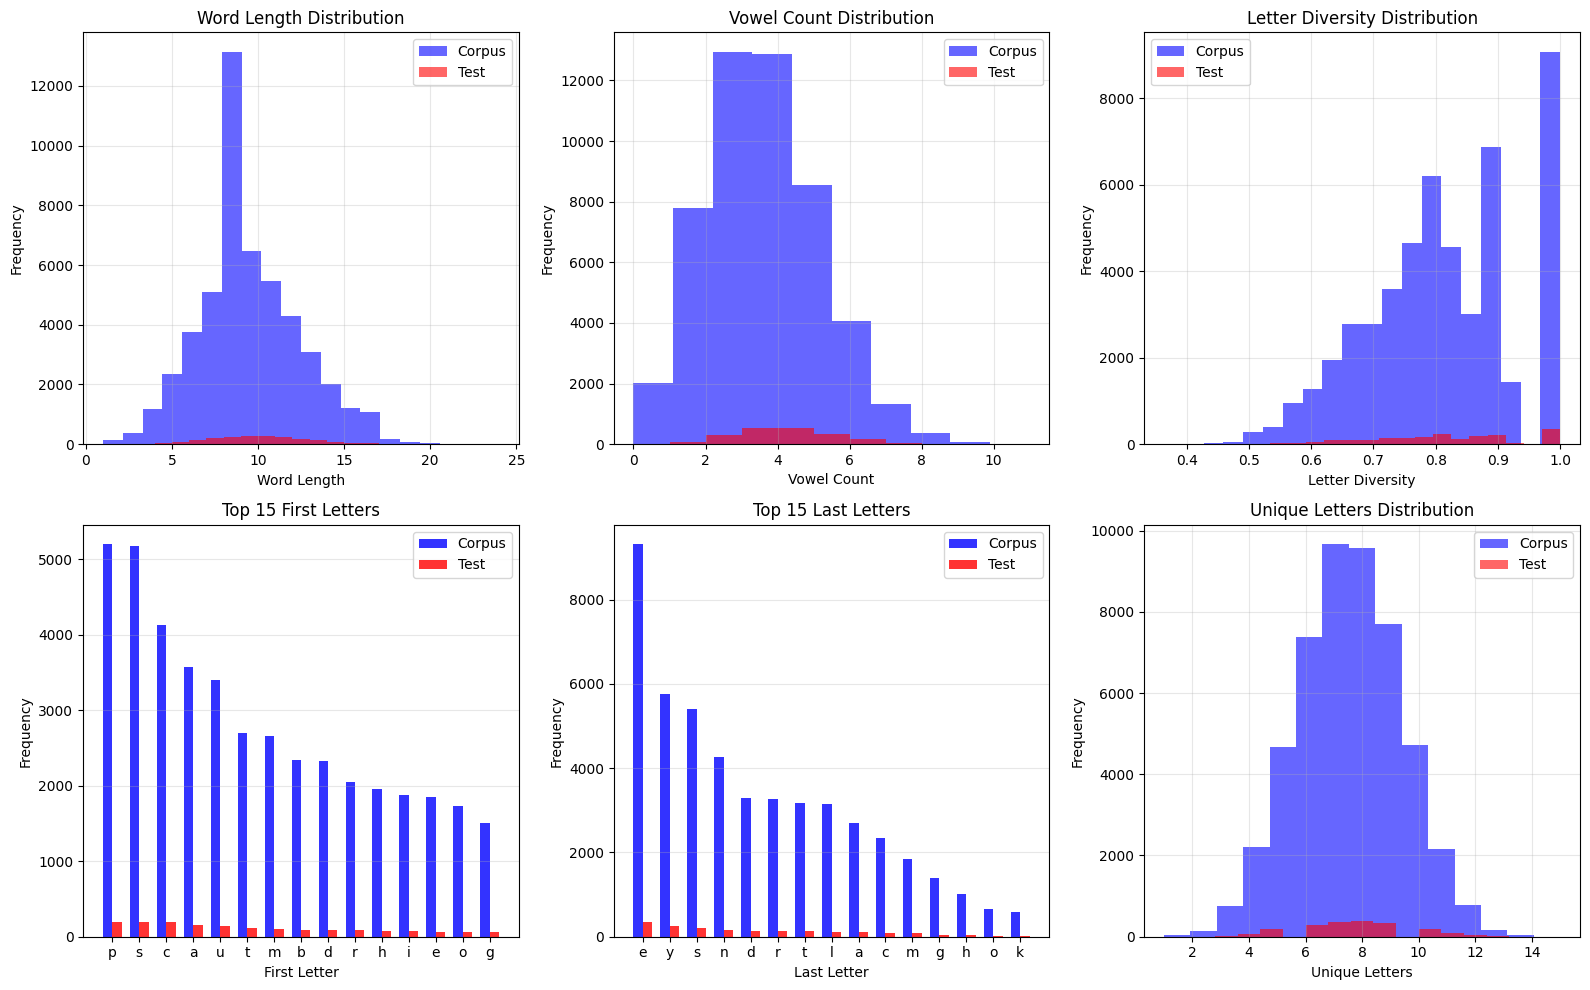


✅ ALL STEPS COMPLETE!


In [7]:
# ========================================
# STEP 4: Save DataFrames
# ========================================
print("\n[STEP 4] Saving DataFrames to CSV...")
corpus_df.to_csv('corpus_features.csv', index=False)
test_df.to_csv('test_features.csv', index=False)
print("✓ Saved: corpus_features.csv")
print("✓ Saved: test_features.csv")

# ========================================
# STEP 5: Create DataLoaders
# ========================================
print("\n[STEP 5] Creating DataLoaders...")

corpus_loader = HangmanDataLoader(corpus_df, batch_size=64, shuffle=True)
test_loader = HangmanDataLoader(test_df, batch_size=32, shuffle=False)

# ========================================
# STEP 6: Test DataLoader
# ========================================
print("\n[STEP 6] Testing DataLoader iteration...")

print("\n🔄 Getting first batch from corpus loader:")
first_batch = next(iter(corpus_loader))
print(f"Batch shape: {first_batch.shape}")
print("\nFirst 3 words in batch:")
print(first_batch[['word', 'length', 'vowel_count']].head(3))

print("\n🔄 Iterating through first 3 batches:")
for i, batch in enumerate(corpus_loader):
    if i >= 3:
        break
    print(f"  Batch {i+1}: {len(batch)} samples, avg length: {batch['length'].mean():.2f}")

# ========================================
# STEP 7: Analyze
# ========================================
print("\n[STEP 7] Analyzing DataFrames...")
corpus_stats = analyze_dataframe(corpus_df, "CORPUS")
test_stats = analyze_dataframe(test_df, "TEST")

# ========================================
# STEP 8: Visualizations
# ========================================
print("\n[STEP 8] Creating visualizations...")
plot_feature_distributions(corpus_df, test_df)

print("\n✅ ALL STEPS COMPLETE!")